In [2]:
from random import sample

from utils import *

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
device = '/device:GPU:0'

# Taking care of the raw data:

In this section [UT Zappos50K](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/) shoe image dataset is read and transformed into edges. In this notebook I used a square [version](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip) of the data. Download it and move it to notebook directory.

In [12]:
!mkdir shoes_data

In [21]:
!unzip -qq ut-zap50k-images-square.zip

In [22]:
!rm ut-zap50k-images-square.zip

In [5]:
# reading images directories:
shoes_dirs = list_all_files('shoes_data/ut-zap50k-images-square')
shoes_dirs = [filename for filename in shoes_dirs if 'edges' not in filename and 'jpg' in filename]
shoes_dirs = sample(shoes_dirs, len(shoes_dirs))

print(f'Total shoes images available: {len(shoes_dirs)}')

Total shoes images available: 50067


In [6]:
# Adding transformed to edges images to overall image directory:
# Commented, because you need to do that only once

#for filename in tqdm(shoes_dirs):
#    gpil = Image.fromarray(np.uint8(image_to_edges(filename)), 'L')
#    gpil.save(edge_filename(filename))

In [7]:
# Resize image to the power of 2:
IMG_HW = 128

In [8]:
# Create list dataset from original images and edges:
list_ds = tf.data.Dataset.from_tensor_slices((shoes_dirs,
                                              list(map(edge_filename, shoes_dirs))))

In [9]:
# Define parsing function to read the data from disk an load it into the model:

def norm_to_abs_one(image):
    return tf.math.subtract(tf.math.multiply(image, 2), 1)

def parse_image(filename, edge_filename):
    # target image
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HW, IMG_HW])
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    # source image:
    edge_image = tf.io.read_file(edge_filename)
    edge_image = tf.image.decode_jpeg(edge_image)
    edge_image = tf.image.convert_image_dtype(edge_image, tf.float32)
    edge_image = tf.image.resize(edge_image, [IMG_HW, IMG_HW])
    # norm to -1, 1
    target_image = norm_to_abs_one(image)
    source_image = norm_to_abs_one(edge_image)
    
    return source_image, target_image

In [10]:
# Parse images directories:
labeled_ds = list_ds.map(parse_image).shuffle(1024)

# Looking at the training data:

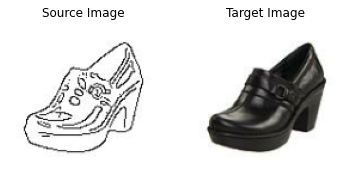

Source shape: (128, 128, 1), Target shape: (128, 128, 3)


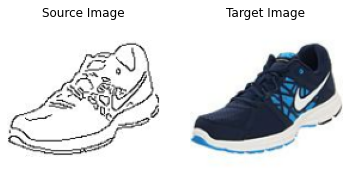

Source shape: (128, 128, 1), Target shape: (128, 128, 3)


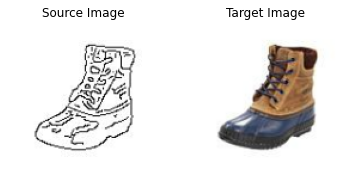

Source shape: (128, 128, 1), Target shape: (128, 128, 3)


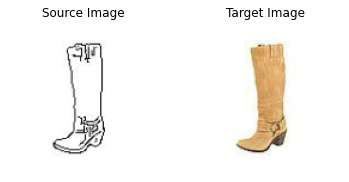

Source shape: (128, 128, 1), Target shape: (128, 128, 3)


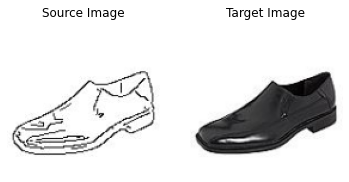

Source shape: (128, 128, 1), Target shape: (128, 128, 3)


In [18]:
   for f in labeled_ds.take(5):
    show(f[0], f[1])
    plt.show()
    print(f'Source shape: {f[0].shape}, Target shape: {f[1].shape}')

In [11]:
# Split dataset into batches:
BATCH_SIZE = 128
train_ds = labeled_ds.shuffle(1024).batch(BATCH_SIZE)

# Defining U-net generator:

Conditional GAN (cGAN, pix2pix) uses U-net as a generator. U-net is an autoencoder model (encoder-decoder) with symmetrical skip connections between corresponding encoder and decoder layers. These skip connections allow to easily transfer some initial details (patterns) to the model outputs, while bottleneck layers are responsible for higher level concepts retrieved during the training. <br/>

The specific thing about U-net generator is the fact that it doesn't use any random noise. Instead, to impose randomness it uses dropout layers that act in training mode both during training and inference.

In [12]:
# define encoder block
def encoder_block(layer_in, filters, batchnorm=True):
    # Initializer:
    init = tf.keras.initializers.GlorotUniform()
    # Downsampling:
    conv = tf.keras.layers.Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # Conditional BatchNorm:
    if batchnorm:
        conv = tf.keras.layers.BatchNormalization()(conv, training=True)
    # Activation:
    conv = tf.keras.layers.LeakyReLU(alpha=0.2)(conv)
    return conv

In [13]:
# define a decoder block
def decoder_block(layer_in, iden_in, filters, dropout=True):
    # Initializer:
    init = tf.keras.initializers.GlorotUniform()
    # Upsampling
    upconv = tf.keras.layers.Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    upconv = tf.keras.layers.BatchNormalization()(upconv, training=True)
    # conditionally add dropout
    if dropout:
        upconv = tf.keras.layers.Dropout(0.5)(upconv, training=True)
    # merge with skip connection
    upconv = tf.keras.layers.Concatenate()([upconv, iden_in])
    # relu activation
    upconv = tf.keras.layers.Activation('relu')(upconv)
    return upconv

In [14]:
# define U-net:
def U_net(input_shape, net_pattern, b_filters, d_dropout_until):
    # Initializer:
    init = tf.keras.initializers.GlorotUniform()
    # Input image:
    in_image = tf.keras.layers.Input(input_shape)
    # iterating through encoder:
    layer_counter = 1
    e_x = in_image
    iden_vec = [] 
    for e_units in net_pattern:
        if layer_counter == 1:
            e_x = encoder_block(e_x, e_units, batchnorm=False)
        else:
            e_x = encoder_block(e_x, e_units)
        iden_vec.append(e_x)
        layer_counter += 1
    # bottleneck, no batch norm and relu
    b = tf.keras.layers.Conv2D(b_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e_x)
    b = tf.keras.layers.Activation('relu')(b)
    # iterating through decoder:
    d_x = b
    layer_counter = 1
    for d_units, identity in zip(net_pattern[::-1], iden_vec[::-1]): 
        if layer_counter <= d_dropout_until:
            d_x = decoder_block(d_x, identity, d_units)
        else:
            d_x = decoder_block(d_x, identity, d_units, dropout=False)
        layer_counter += 1
    # output
    out = tf.keras.layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d_x)
    out_image = tf.keras.layers.Activation('tanh')(out)
    # define model
    model = tf.keras.models.Model(in_image, out_image)
    return model

In [15]:
generator = U_net(input_shape=[IMG_HW, IMG_HW, 1],
                  net_pattern=[64, 128, 128, 256, 384, 512],
                  b_filters=512,
                  d_dropout_until=3)

In [16]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1088        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Create PatchGAN Discriminator:

As a dicriminator cGAN uses PatchGAN discriminator.
Two main differences from vanilla GAN discriminator are:

1) PatchGAN classifies whether the image real or fake on its every region (tipycally 70x70 pixels) instead of taking the full image

2) PatchGAN takes not only generated fakes as an input, but also the source images that they were generated from

In [17]:
# def Patch-GAN layer:
def patch_gan_block(layer_in, filters, batchnorm=True):
    # Initializer:
    init = tf.keras.initializers.GlorotUniform()
    # Downsampling:
    conv = tf.keras.layers.Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # Conditional BatchNorm:
    if batchnorm:
        conv = tf.keras.layers.BatchNormalization()(conv)
    # Activation:
    conv = tf.keras.layers.LeakyReLU(alpha=0.2)(conv)
    return conv

In [18]:
def PatchGAN_net(input_image_shape, target_image_shape,
                 net_pattern, second_last_filters):
    # weight initialization
    init = tf.keras.initializers.GlorotUniform()
    # source image input
    in_src_image = tf.keras.layers.Input(shape=input_image_shape)
    # target image input
    in_target_image = tf.keras.layers.Input(shape=target_image_shape)
    # concatenate images channel-wise
    merged = tf.keras.layers.Concatenate()([in_src_image, in_target_image])
    # moving down by Conv Net:
    x = merged
    layer_counter = 1
    for units in net_pattern:
        if layer_counter == 1:
            x = patch_gan_block(x, units, batchnorm=False)
        else:
            x = patch_gan_block(x, units)
        layer_counter += 1
    # second last output layer
    d = tf.keras.layers.Conv2D(second_last_filters, (4,4), padding='same', kernel_initializer=init)(x)
    d = tf.keras.layers.BatchNormalization()(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init,
                                       activation=None)(d)
    # define model
    model = tf.keras.models.Model([in_src_image, in_target_image], patch_out)
    return model

In [19]:
discriminator = PatchGAN_net(input_image_shape=[IMG_HW, IMG_HW, 1],
                             target_image_shape=[IMG_HW, IMG_HW, 3],
                             net_pattern=[32, 64, 128, 256],
                             second_last_filters=384)

In [20]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 128, 128, 4)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 32)   2080        concatenate_6[0][0]        

# Set up loss for GAN

Mainly losses for cGAN are the same as for vanilla GAN, except 2 major differences:

1) Discriminator loss is multiplied by 0.5 to slow down it training

2) Generator loss along with adversarial loss uses L1 loss term (target reconstruction) multiplied by weight lambda (100 in original [paper](https://arxiv.org/abs/1611.07004))

In [21]:
def discriminator_loss(logits_real, logits_fake):
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_labels, fake_labels = tf.ones(logits_real.shape), tf.zeros(logits_fake.shape)
    real_loss = tf.reduce_mean(loss_fn(real_labels, logits_real))
    fake_loss = tf.reduce_mean(loss_fn(fake_labels, logits_fake))
    loss = tf.math.add(real_loss, fake_loss)
    loss = tf.math.multiply(loss, 0.5) # used to slow down discriminator training
    return loss

def generator_loss(logits_fake, generated_image, target_image, l1_lambda=100):
    adversarial_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    l1_loss_fn = tf.keras.losses.MAE
    fake_labels = tf.ones(logits_fake.shape)
    adversarial_loss = adversarial_loss_fn(fake_labels, logits_fake)
    l1_loss = l1_loss_fn(target_image, generated_image)
    l1_loss = tf.math.multiply(l1_loss, l1_lambda)
    l1_loss = tf.math.reduce_mean(l1_loss)
    loss = tf.math.add(adversarial_loss, l1_loss)
    return loss

# Specify GAN training loop:

tf.Tensor([128 128 128   3], shape=(4,), dtype=int32)


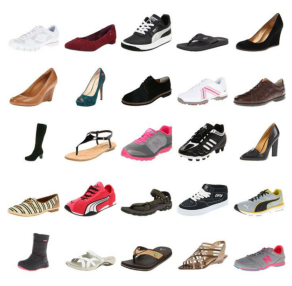

tf.Tensor([128 128 128   3], shape=(4,), dtype=int32)


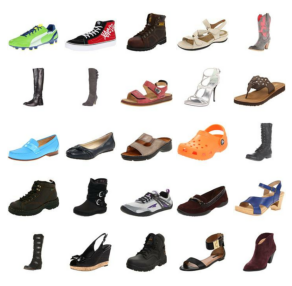

In [22]:
max_print = 1
counter = 0
for data_batch in train_ds:
    counter += 1
    real_imgs = data_batch[1]
    print(tf.shape(real_imgs))
    show_tf_batch(real_imgs)
    plt.show()
    if counter > max_print:
        break

In [23]:
class cGANSolver(object):
    
    def __init__(self, G, D, G_loss, D_loss, G_solver, D_solver):
        self.G = G
        self.D = D
        self.G_loss = G_loss
        self.D_loss = D_loss
        self.G_solver = G_solver
        self.D_solver = D_solver
        
        self.checkpoint_prefix = None
        self.checkpoint = None
    
    def create_checkpoint(self, cp_path):
        
        self.checkpoint_prefix = os.path.join(cp_path, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.G_solver,
                                              discriminator_optimizer=self.D_solver,
                                              generator=self.G,
                                              discriminator=self.D)
        
    def restore_checkpoint(self, cp_path):
        
        if self.checkpoint is None:
            self.create_checkpoint(cp_path=cp_path)
            
        self.checkpoint.restore(tf.train.latest_checkpoint(cp_path)).expect_partial()
        
        self.G = self.checkpoint.generator
        self.D = self.checkpoint.discriminator
        self.G_solver = self.checkpoint.generator_optimizer
        self.D_solver = self.checkpoint.discriminator_optimizer
    
    def train(self, train_data, num_epochs, show_every=50, cp_path=None):
        
        if cp_path is not None:
            self.create_checkpoint(cp_path=cp_path)
            
        for ep in range(num_epochs):     
            iter_counter = 0
            for data_batch in train_data:
                source_imgs, real_imgs = data_batch[0], data_batch[1]
                with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                    real_logits = self.D([source_imgs, real_imgs])
                    fake_imgs = self.G(source_imgs)
                    fake_logits = self.D([source_imgs, fake_imgs])
                    # Updating generator:
                    gen_loss = self.G_loss(fake_logits, source_imgs, real_imgs)
                    gen_grads = gen_tape.gradient(gen_loss, self.G.trainable_variables)
                    self.G_solver.apply_gradients(zip(gen_grads, self.G.trainable_variables))
                    # Updating discriminator:
                    disc_loss = self.D_loss(real_logits, fake_logits)
                    disc_grads = disc_tape.gradient(disc_loss, self.D.trainable_variables)
                    self.D_solver.apply_gradients(zip(disc_grads, self.D.trainable_variables))
                    
                iter_counter += 1
                if iter_counter % show_every == 0:
                    print(f'Epoch: {ep}, Iter: {iter_counter}, D: {disc_loss}, G:{gen_loss}')
                    show_tf_batch(fake_imgs, n_img=25)
                    plt.show()
                    
            if self.checkpoint is not None:
                print(f'Saving GAN to {cp_path}, epoch No. {ep}')
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                

In [24]:
shoes_gan = cGANSolver(G=U_net(input_shape=[IMG_HW, IMG_HW, 1],
                               net_pattern=[64, 128, 128, 256, 384, 512],
                               b_filters=512,
                               d_dropout_until=3),
                       D=PatchGAN_net(input_image_shape=[IMG_HW, IMG_HW, 1],
                                      target_image_shape=[IMG_HW, IMG_HW, 3],
                                      net_pattern=[32, 64, 128, 256],
                                      second_last_filters=384),
                       G_loss=generator_loss,
                       D_loss=discriminator_loss,
                       G_solver=tf.keras.optimizers.Adam(),
                       D_solver=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

In [186]:
# Restore checkpoint if needed to continue training:

# shoes_gan.restore_checkpoint('./gan_checkpoints6')

In [95]:
print(f"Estimated epoch size {shoes_dirs.__len__() / BATCH_SIZE} iterations")

Estimated epoch size 391.1484375 iterations


Epoch: 0, Iter: 380, D: 0.09733790904283524, G:38.896018981933594


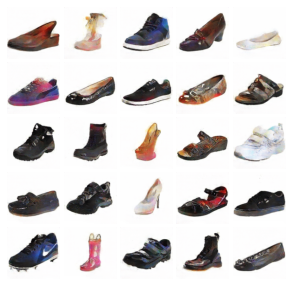

Saving GAN to None, epoch No. 0


In [57]:
# this demonstration loop was not run from the beggining
# that is why images look realistic right from the start

with tf.device(device):
    shoes_gan.train(train_data=train_ds, num_epochs=1, 
                    show_every=380, cp_path='./gan_checkpoints')

In [42]:
shoes_gan.G_solver.iterations

<tf.Variable 'iter:0' shape=() dtype=int64, numpy=211288>

# Looking at the results:

In [69]:
rand_batch = next(iter(train_ds))

In [70]:
fitted_batch = shoes_gan.G(rand_batch[0])

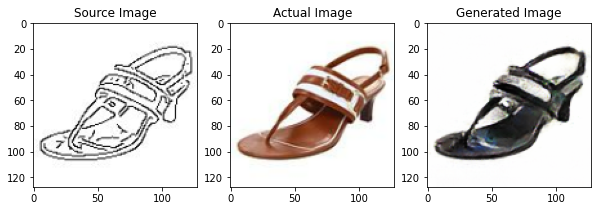

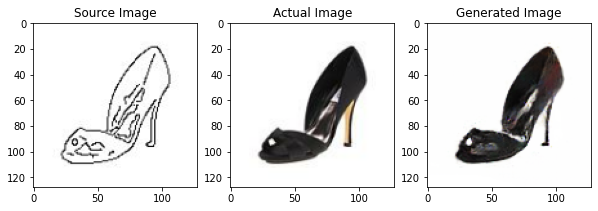

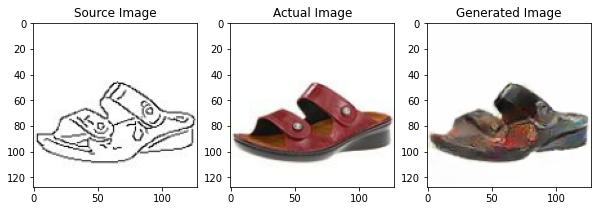

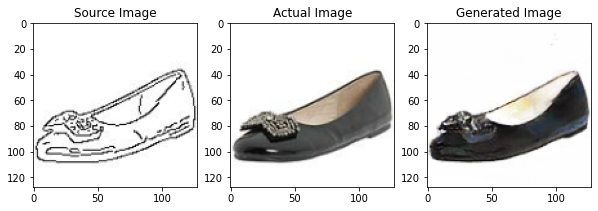

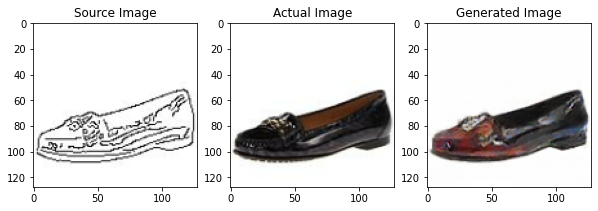

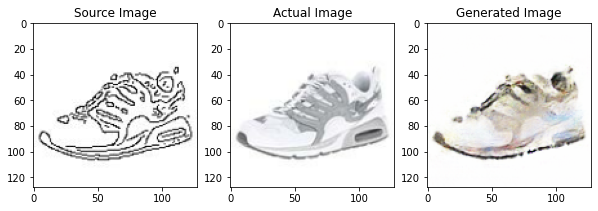

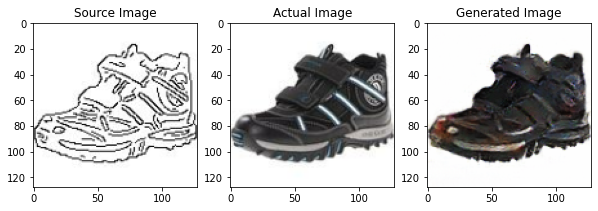

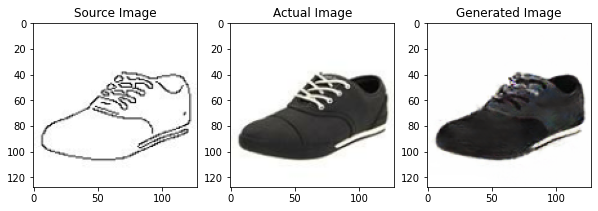

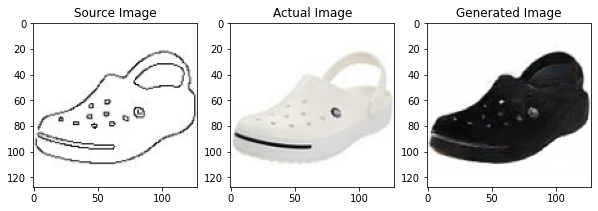

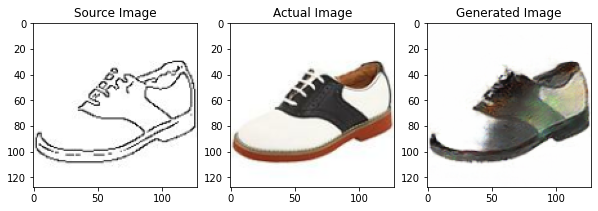

In [71]:
def show_res(source_image, actual_image, restored_image):
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 3, 1)
    plt.title('Source Image')
    plt.imshow((source_image[:, :, 0] + 1) / 2, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('Actual Image')
    plt.imshow((actual_image + 1) / 2)
    plt.subplot(1, 3, 3)
    plt.title('Generated Image')
    plt.imshow((restored_image + 1) / 2)
    
for index in np.random.choice(range(0, BATCH_SIZE), 10, replace=False):
    restored_image = fitted_batch[index]
    actual_image = rand_batch[1][index]
    gr_image = rand_batch[0][index]
    show_res(gr_image, actual_image, restored_image)

# Transforming user-painted sketches:

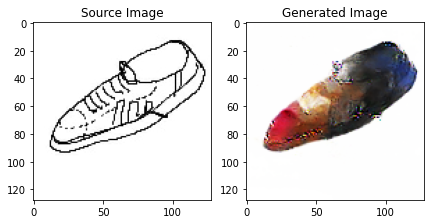

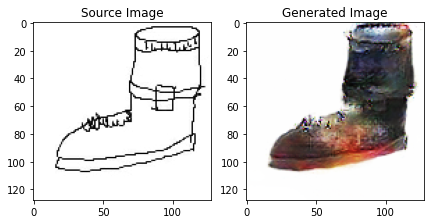

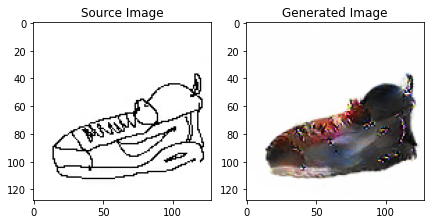

In [127]:
sketches_dir = 'user_sketches'
for user_file in os.listdir(sketches_dir):
    # source image:
    if 'jpg' in user_file:
        edge_image = tf.io.read_file(f'{sketches_dir}/{user_file}')
        edge_image = tf.image.decode_jpeg(edge_image)
        edge_image = tf.image.convert_image_dtype(edge_image, tf.float32)
        edge_image = tf.image.resize(edge_image, [IMG_HW, IMG_HW])
        if tf.shape(edge_image)[2] == 3:
            edge_image = tf.image.rgb_to_grayscale(edge_image)
        # norm to -1, 1
        source_image = norm_to_abs_one(edge_image)
        # Generate with cGAN
        generated_image = shoes_gan.G(source_image[tf.newaxis, :, :, :])[0]
        # Plot the results
        plt.figure(figsize=(7, 5))
        plt.subplot(1, 2, 1)
        plt.title('Source Image')
        plt.imshow((source_image[:, :, 0] + 1) / 2, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title('Generated Image')
        plt.imshow((generated_image + 1) / 2)
        plt.show()